<a href="https://colab.research.google.com/github/d61h6k4/notebooks/blob/master/PyTorch_tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[What is torch.nn really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

In [0]:
import gzip
import math
import pathlib
import pickle
import requests
import torch

import numpy as np
import matplotlib.pyplot as plt

In [0]:
DATA_PATH = pathlib.Path("data")
PATH= DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [0]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

5


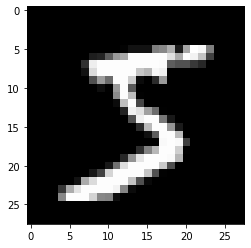

In [5]:
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(y_train[0])

In [6]:

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [0]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

softmax:
$$
\sigma_{z_i} = \frac{e^{z_i}}{\sum_k^K e^{z_k}}
$$
log softmax = ln(softmax)
$$
\ln(\sigma_{z_i}) = \ln(\frac{e^{z_i}}{\sum_k^K e^{z_k}}) = \ln(e^{z_i}) - \ln(\sum_k^K e^{z_k}) = z_i - \ln(\sum_k^K e^{z_k})
$$

In [0]:
def log_softmax(x: torch.Tensor) -> torch.Tensor:
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb: torch.Tensor) -> torch.Tensor:
    return log_softmax(xb @ weights + bias)

In [9]:
BATCH_SIZE = 64

xb = x_train[:BATCH_SIZE]
preds = model(xb)

print(preds[0], preds.shape)

tensor([-2.2308, -2.6081, -2.4464, -2.3784, -2.3840, -2.8088, -1.7293, -2.8653,
        -1.8638, -2.3261], grad_fn=<SelectBackward>) torch.Size([64, 10])


Negative log likelihood is -log(likelihood) :D

likelihood is $\mathcal{L}(\theta | x) = p_{\theta}(x)$

softmax gives probability, log(softmax) has already contained logarithm

In [0]:
def nll(pred, target):
    return -pred[range(target.shape[0]), target].mean()

loss_func = nll

In [11]:
yb = y_train[0:BATCH_SIZE]
print(loss_func(preds, yb))

tensor(2.4116, grad_fn=<NegBackward>)


In [0]:
def accuracy(pred, target):
    return (torch.argmax(pred, dim=1) == target).float().mean()

In [13]:
print(accuracy(preds, yb))

tensor(0.0312)


In [0]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // BATCH_SIZE + 1):
        start_i = i * BATCH_SIZE
        end_i = start_i + BATCH_SIZE

        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]

        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [19]:

xb = x_train[:BATCH_SIZE]
preds = model(xb)

yb = y_train[0:BATCH_SIZE]
print(loss_func(preds, yb))
print(accuracy(preds, yb))

tensor(0.2255, grad_fn=<NegBackward>)
tensor(0.9531)


In [0]:
loss_func = torch.nn.functional.cross_entropy

def model(xb):
    return xb @ weights + bias

In [21]:

xb = x_train[:BATCH_SIZE]
preds = model(xb)

yb = y_train[0:BATCH_SIZE]
print(loss_func(preds, yb))
print(accuracy(preds, yb))

tensor(0.2255, grad_fn=<NllLossBackward>)
tensor(0.9531)


In [0]:
class Mnist_Logistic(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = torch.nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [0]:
model = Mnist_Logistic()

In [27]:
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(2.3128, grad_fn=<NllLossBackward>)
tensor(0.1250)


In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // BATCH_SIZE + 1):
            start_i = i * BATCH_SIZE
            end_i = start_i + BATCH_SIZE
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [30]:
print(loss_func(model(x_valid), y_valid), accuracy(model(x_valid), y_valid))

tensor(0.2935, grad_fn=<NllLossBackward>) tensor(0.9182)


In [0]:
class Mnist_Logistic(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = torch.nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [33]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3237, grad_fn=<NllLossBackward>)


In [34]:
fit()

print(loss_func(model(xb), yb))
print(loss_func(model(x_valid), y_valid), accuracy(model(x_valid), y_valid))

tensor(0.2273, grad_fn=<NllLossBackward>)
tensor(0.2928, grad_fn=<NllLossBackward>) tensor(0.9181)


In [36]:
def get_model():
    model = Mnist_Logistic()
    return model, torch.optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // BATCH_SIZE + 1):
        start_i = i * BATCH_SIZE
        end_i = start_i + BATCH_SIZE
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3215, grad_fn=<NllLossBackward>)
tensor(0.0814, grad_fn=<NllLossBackward>)


In [37]:
print(loss_func(model(x_valid), y_valid), accuracy(model(x_valid), y_valid))

tensor(0.2923, grad_fn=<NllLossBackward>) tensor(0.9179)


In [39]:
train_ds = torch.utils.data.TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // BATCH_SIZE + 1):
        xb, yb = train_ds[i * BATCH_SIZE: i * BATCH_SIZE + BATCH_SIZE]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward>)


In [41]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE)
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))


tensor(0.0818, grad_fn=<NllLossBackward>)


In [0]:
train_ds = torch.utils.data.TensorDataset(x_train, y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

valid_ds = torch.utils.data.TensorDataset(x_valid, y_valid)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE * 2)

In [45]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3123)
1 tensor(0.3129)


In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True),
        torch.utils.data.DataLoader(valid_ds, batch_size=bs * 2),
    )

In [54]:
train_dl, valid_dl = get_data(train_ds, valid_ds, BATCH_SIZE)
model, opt = get_model()
fit(10, model, loss_func, opt, train_dl, valid_dl)

0 0.29234937291145324
1 0.2816196670055389
2 0.29964856300354004
3 0.3197982791185379
4 0.2806542938709259
5 0.2844749162256718
6 0.35318189092874525
7 0.346016840672493
8 0.2664547397494316
9 0.2982609001159668


In [0]:
class Mnist_CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = torch.nn.functional.relu(self.conv1(xb))
        xb = torch.nn.functional.relu(self.conv2(xb))
        xb = torch.nn.functional.relu(self.conv3(xb))
        xb = torch.nn.functional.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [59]:
model = Mnist_CNN()
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3119875155925751
1 0.26652809740304945


In [0]:
class Lambda(torch.nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [62]:
model = torch.nn.Sequential(
    Lambda(preprocess),
    torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.40720802450180055
1 0.24283266565799713


In [63]:
accuracy(model(x_valid), y_valid)

tensor(0.9247)